In [1]:
import pandas as pd
import numpy as np
import os
import talib
import scipy.optimize as sco
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from price_functions import PricesDataFrame
from utils import logreturn_to_return, return_to_logreturn, value_at_risk
import math

In [2]:
data = pd.DataFrame.from_csv('ativos_2.csv')

/home/brunocape/.virtualenvs/jordan/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


#Abrir dados

appended_data = []
date_format = '%Y-%m-%d'

for entry in os.scandir('../data_crypto/USDT'):
    if entry.is_file():
        symbol = (os.path.splitext(entry.name)[0])
        df_entry = pd.read_json(entry.path)
        df_entry = df_entry[['date','open', 'close', 'high', 'low']]
        df_entry['symbol'] = symbol
        appended_data.append(df_entry)


data = pd.concat(appended_data)
data = data.set_index('date')
data = data.pivot(columns='symbol', values='close').dropna()

In [3]:
data.describe()

,AAPL,MSFT,GOOG,TWTR,NVDA,V,NFLX,FB,AMZN,INTC,...,BAC,AMD,PEP,ATVI,C,F,AABA,BA,CSCO,WMT
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,...,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,167.824819,84.638750,1007.292278,24.712681,189.875363,112.779194,236.555988,163.655302,1270.626976,42.965907,...,27.117036,14.417843,111.415323,62.506573,67.804536,11.282540,62.730968,273.008831,38.027157,84.713528
std,28.376726,16.442254,128.353812,8.641600,57.798624,20.636937,88.898912,21.268510,382.296766,6.777263,...,3.270382,5.027426,5.394564,11.690231,5.856616,1.079181,11.953437,75.549500,5.980559,10.630643
min,109.110000,59.950000,759.110000,14.290000,89.590000,77.110000,119.160000,115.050000,749.870000,33.460000,...,21.840000,8.680000,96.160000,36.110000,55.680000,8.180000,38.410000,152.160000,29.330000,65.660000
25%,146.942500,69.447500,922.842500,17.287500,144.172500,94.130000,156.432500,149.795000,957.992500,36.260000,...,23.877500,11.395000,108.680000,56.567500,62.040000,10.787500,50.650000,187.982500,32.187500,76.017500
50%,167.170000,84.115000,1021.045000,21.115000,197.630000,111.975000,195.525000,167.915000,1157.975000,44.395000,...,27.445000,12.865000,112.165000,64.285000,68.435000,11.295000,66.520000,268.645000,37.305000,85.185000
75%,186.342500,98.367500,1104.167500,31.852500,242.705000,131.127500,321.772500,178.920000,1600.490000,48.370000,...,30.132500,14.670000,115.510000,71.080000,72.380000,12.137500,72.107500,344.682500,43.750000,94.180000
max,232.070000,115.610000,1268.330000,46.760000,289.360000,150.790000,418.970000,217.500000,2039.510000,57.080000,...,32.840000,32.720000,121.760000,83.390000,80.080000,13.230000,82.360000,392.300000,49.140000,109.550000


In [4]:
TAMANHO_TREINO = 0.5
qt_dados_treinamento = int(round((len(data)*TAMANHO_TREINO), 0))
df_prices = PricesDataFrame(data[:qt_dados_treinamento]) 
df_prices_test = PricesDataFrame(data[qt_dados_treinamento:])
df_prices_all = PricesDataFrame(data)

/home/brunocape/Projects/pyfinance/pynance/price_functions.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prices.sort_index(inplace=True)


In [5]:
df_returns = df_prices.returns()

In [6]:
value_at_risk(0.95, df_prices.mean_returns().loc['AAPL'], df_prices.variance().loc['AAPL'], 100)

-11.860551608545311

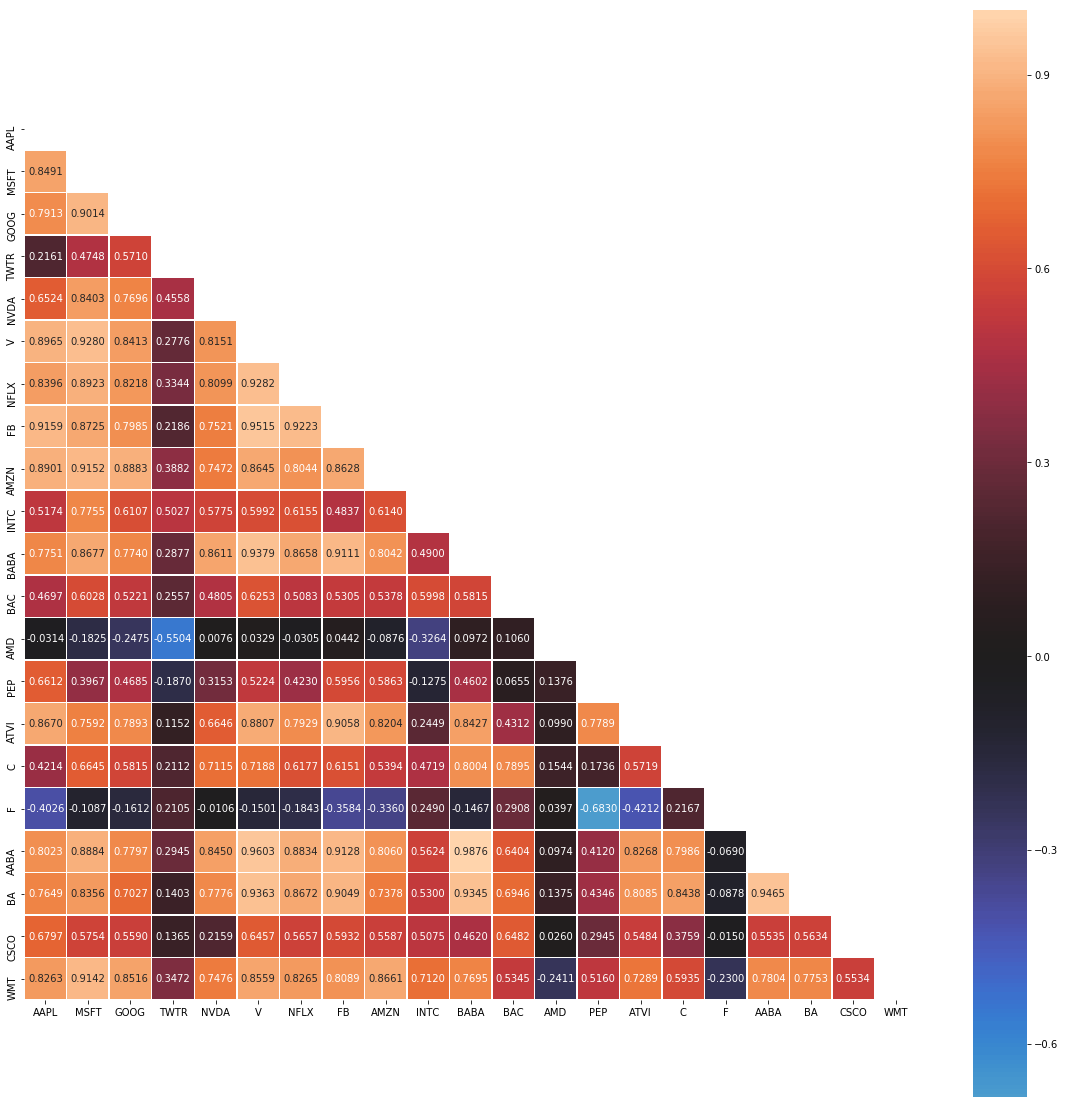

In [7]:
corr = df_prices.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

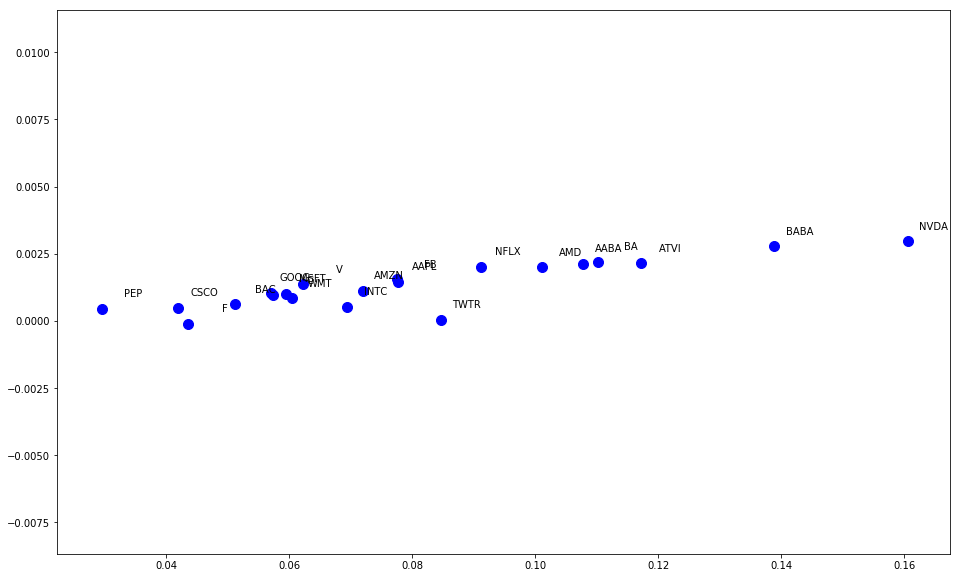

In [8]:
fig= plt.figure(figsize=(16,10))
for asset in df_prices.mean_returns().index:
    plt.scatter(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset],marker='o',color='b',s=100, label=asset)
    plt.annotate(asset,
             xy=(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset]),
             xytext=(40, 10),
             textcoords='offset points',
             ha='right',
             va='bottom')


plt.show()

In [9]:
for symbol in df_prices.mean_returns().index:
    var = value_at_risk(0.95, df_prices.mean_returns().loc[symbol], df_prices.variance().loc[symbol], 100)
    print(f'Value at risk {symbol}: {var}')

Value at risk AAPL: -11.860551608545311
Value at risk MSFT: -9.231711180209112
Value at risk GOOG: -8.859303599645374
Value at risk TWTR: -12.992763030035604
Value at risk NVDA: -22.995990513108943
Value at risk V: -9.611805728568479
Value at risk NFLX: -13.750986162680567
Value at risk FB: -11.827372809671811
Value at risk AMZN: -11.07976026839137
Value at risk INTC: -10.750074635722306
Value at risk BABA: -20.189658475400606
Value at risk BAC: -8.027589167077775
Value at risk AMD: -15.153110793944958
Value at risk PEP: -4.709565570659635
Value at risk ATVI: -17.360268425670178
Value at risk C: -8.928598004930377
Value at risk F: -6.9260649542278845
Value at risk AABA: -16.062911606781284
Value at risk BA: -16.390198828604063
Value at risk CSCO: -6.628120440427909
Value at risk WMT: -9.38600535307642


In [10]:
rf = return_to_logreturn(0.000078)

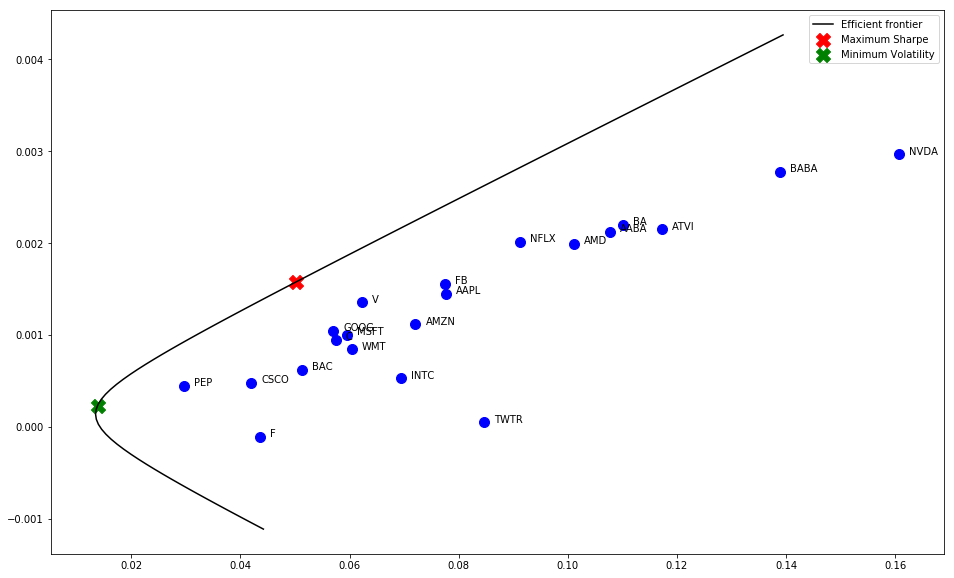

In [11]:
df_prices.plot_efficient_frontier(rf, use_negative=False)

In [12]:
ef = df_prices.efficient_frontier(rf, use_negative=True)
ef_without_neg = df_prices.efficient_frontier(rf, use_negative=False)

In [13]:
pmv_without_negative = df_prices.min_volatility(use_negative=False)
pt_without_negative = df_prices.max_sharpe(rf,use_negative=False)

In [15]:
pmv = df_prices.min_volatility()
pt = df_prices.max_sharpe(rf)

In [16]:
var = value_at_risk(0.95, pmv['portfolio_return'], pmv['portfolio_volatility'], 100)
print(f'Value at risk PMV: {var}')
var = value_at_risk(0.95, pt['portfolio_return'], pt['portfolio_volatility'], 100)
print(f'Value at risk PT: {var}')

Value at risk PMV: -1.172938796621248
Value at risk PT: -4.374098087266254


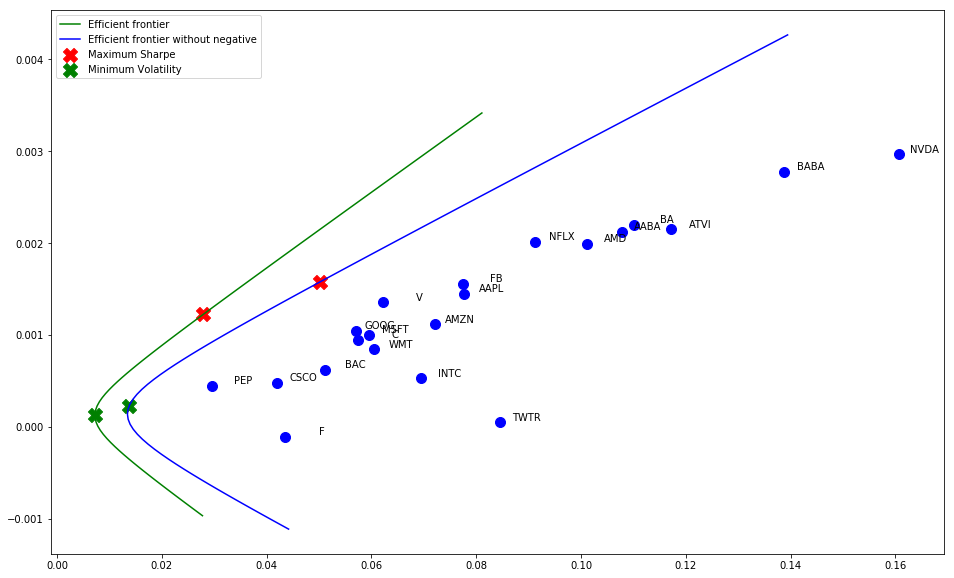

In [17]:
fig= plt.figure(figsize=(16,10))
plt.plot( 'portfolio_volatility', 'portfolio_return', data=ef, color='green')
plt.scatter(pt['portfolio_volatility'], pt['portfolio_return'], marker='X',color='r',s=200, label='Maximum Sharpe')
plt.scatter(pmv['portfolio_volatility'], pmv['portfolio_return'],marker='X',color='g',s=200, label='Minimum Volatility')
plt.plot( 'portfolio_volatility', 'portfolio_return', data=ef_without_neg, color='blue')
plt.scatter(pt_without_negative['portfolio_volatility'], pt_without_negative['portfolio_return'], marker='X',color='r',s=200, label='Maximum Sharpe')
plt.scatter(pmv_without_negative['portfolio_volatility'], pmv_without_negative['portfolio_return'],marker='X',color='g',s=200, label='Minimum Volatility')

for asset in df_prices.mean_returns().index:
    plt.scatter(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset],marker='o',color='b',s=100, label=asset)
    plt.annotate(asset,
             xy=(df_prices.variance().loc[asset], df_prices.mean_returns().loc[asset]),
             xytext=(40, 0),
             textcoords='offset points',
             ha='right',
             va='bottom')

plt.legend(['Efficient frontier','Efficient frontier without negative', 'Maximum Sharpe', 'Minimum Volatility'])
plt.show()

In [18]:
weights_pmv = pmv['weights']
weights_pt = pt['weights']
weights_pmv_without_negative = pmv_without_negative['weights']
weights_pt_without_negative = pt_without_negative['weights']

In [19]:
return_pmv = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pmv))
return_pt = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pt))
return_pmv_without_negative = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pmv_without_negative))
return_pt_without_negative = logreturn_to_return(df_prices_test.portfolio_return_for_all_period(weights_pt_without_negative))

print(f'Retorno PMV: {return_pmv_without_negative}')
print(f'Retorno PT: {return_pt_without_negative}')

print('Com negativos')
print(f'Retorno PMV: {return_pmv}')
print(f'Retorno PT: {return_pt}')

Retorno PMV: -0.08794246489779867
Retorno PT: 0.3900812730684886
Com negativos
Retorno PMV: -0.19763454310239015
Retorno PT: 0.4878679838207849


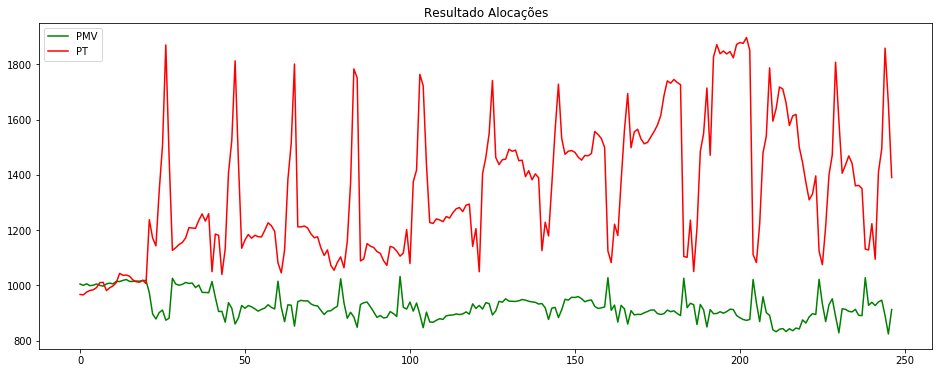

In [20]:
return_pmv = df_prices_test.portfolio_value_for_row(weights_pmv_without_negative, 1000)
return_pt = df_prices_test.portfolio_value_for_row(weights_pt_without_negative, 1000)
fig= plt.figure(figsize=(16,6))
plt.title('Resultado Alocações')
plt.plot('portfolio_return', data=return_pmv.reset_index(), color='green')
plt.plot('portfolio_return', data=return_pt.reset_index(), color='red')
plt.legend(['PMV', 'PT'])

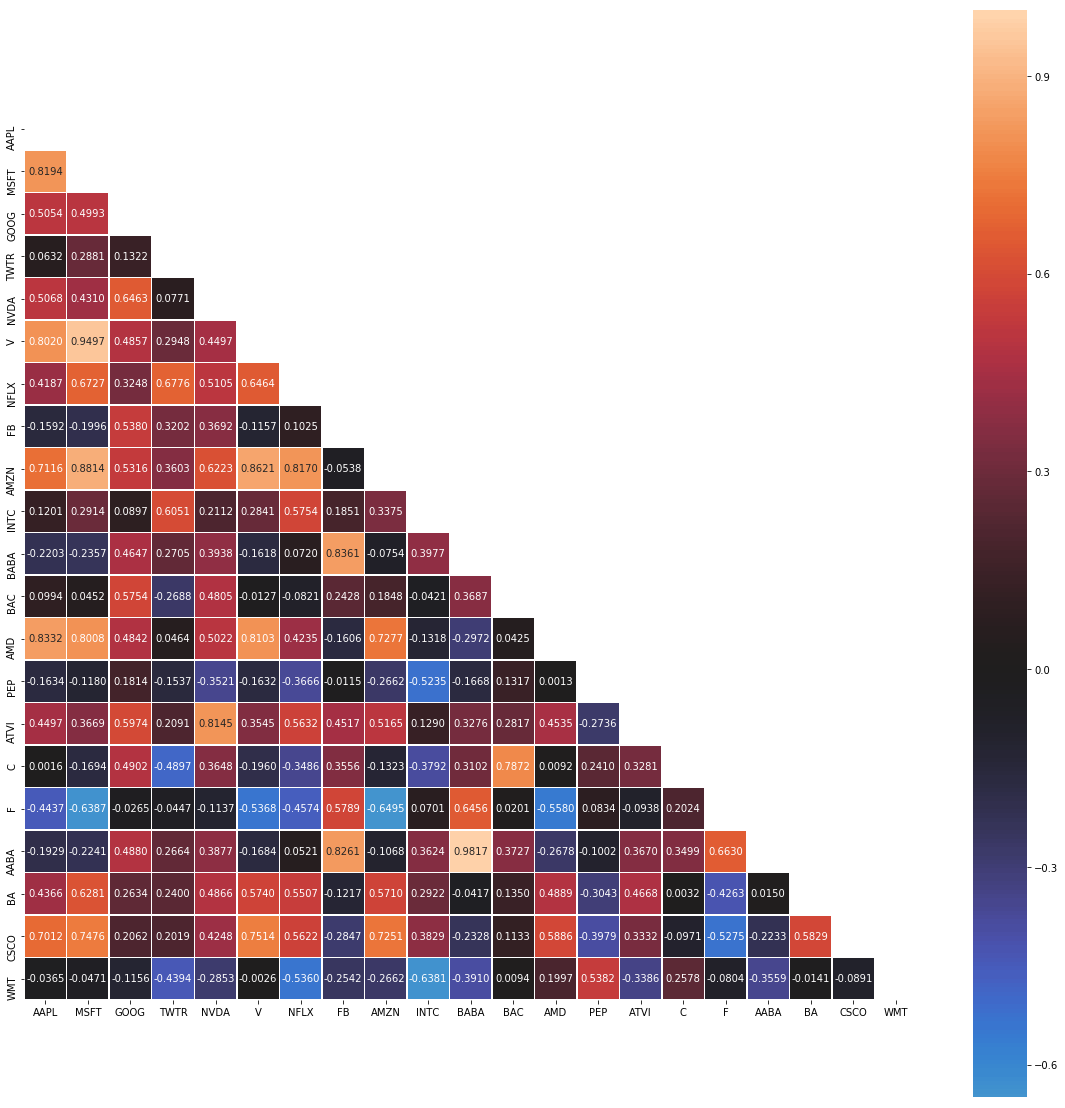

In [21]:
#Mudança de cenário 2018

corr = df_prices_test.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

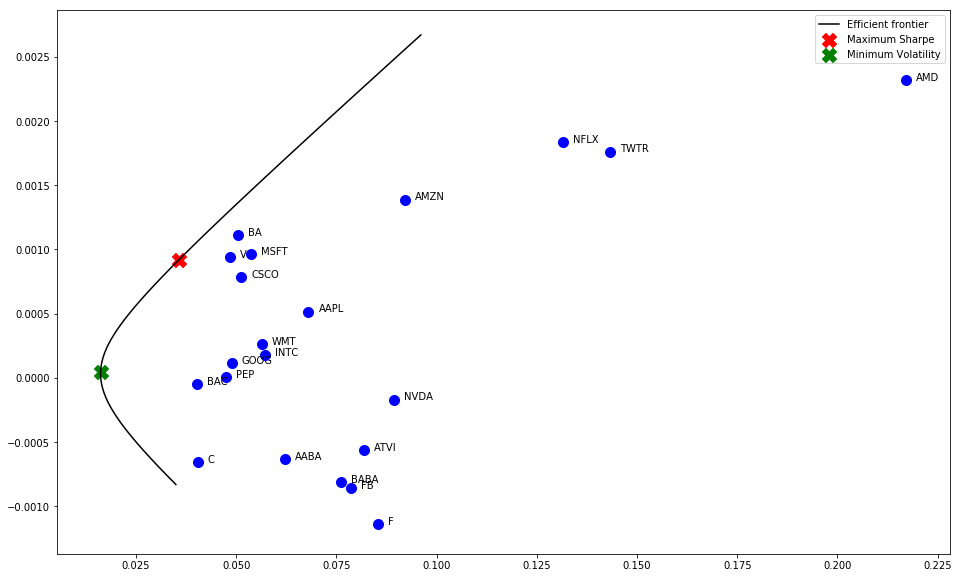

In [22]:
df_prices_test.plot_efficient_frontier(rf, use_negative=False)

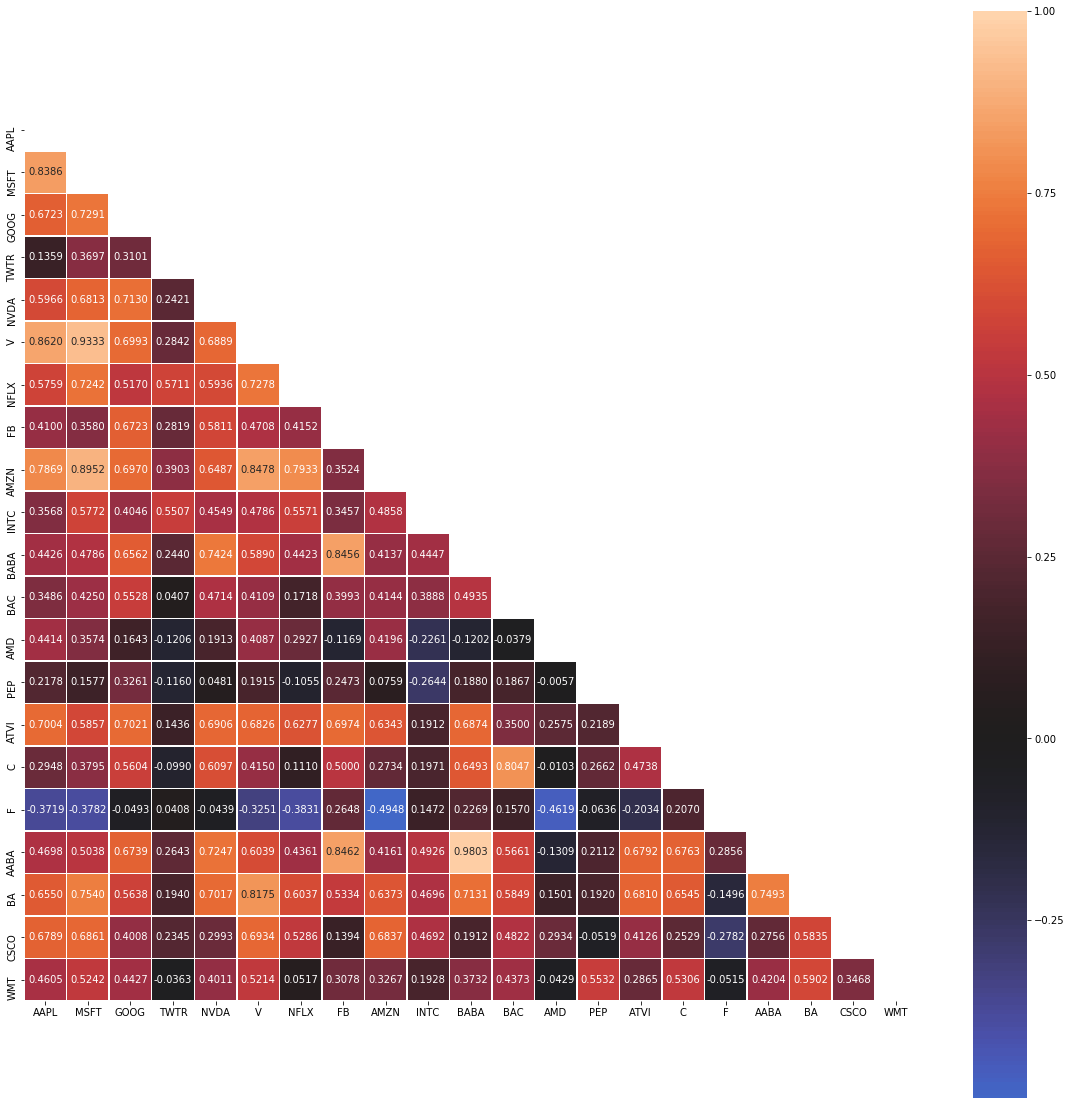

In [23]:
corr = df_prices_all.correlation()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

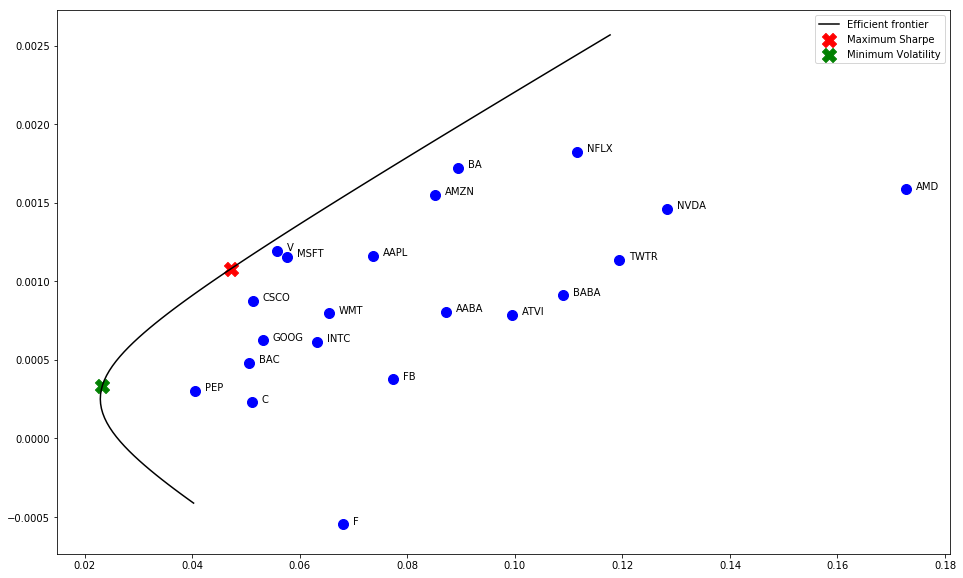

In [24]:
df_prices_all.plot_efficient_frontier(rf, use_negative=False)